In [2]:
# import all necessary stuff
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

In [3]:
# import and read in CSV
amazon_data_path = "Resources/Amazon_Data.csv"

amazon_data = pd.read_csv(amazon_data_path, delimiter=',', header=0)

In [4]:
# create starter data frame from CSV
amazon_df = pd.DataFrame(amazon_data)

amazon_df.head()

,Index,Timestamp,age,Gender,Purchase_Frequency,Purchase_Categories,Personalized_Recommendation_Frequency,Browsing_Frequency,Product_Search_Method,Search_Result_Exploration,...,Saveforlater_Frequency,Review_Left,Review_Reliability,Review_Helpfulness,Personalized_Recommendation_Frequency,Recommendation_Helpfulness,Rating_Accuracy,Shopping_Satisfaction,Service_Appreciation,Improvement_Areas
0,1,2023/06/04 1:28:19 PM GMT+5:30,23,Female,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,...,Sometimes,Yes,Occasionally,Yes,2,Yes,1,1,Competitive prices,Reducing packaging waste
1,2,2023/06/04 1:28:19 PM GMT+5:31,23,Female,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,...,Rarely,No,Heavily,Yes,2,Sometimes,3,2,Wide product selection,Reducing packaging waste
2,3,2023/06/04 1:28:19 PM GMT+5:32,24,Prefer not to say,Few times a month,"Groceries and Gourmet Food,Clothing and Fashion",No,Few times a month,Keyword,Multiple pages,...,Rarely,No,Occasionally,No,4,No,3,3,Competitive prices,Product quality and accuracy
3,4,2023/06/04 1:28:19 PM GMT+5:33,24,Female,Once a month,"Beauty and Personal Care,Clothing and Fashion,...",Sometimes,Few times a month,Keyword,First page,...,Sometimes,Yes,Heavily,Yes,3,Sometimes,3,4,Competitive prices,Product quality and accuracy
4,5,2023/06/04 1:28:19 PM GMT+5:34,22,Female,Less than once a month,"Beauty and Personal Care,Clothing and Fashion",Yes,Few times a month,Filter,Multiple pages,...,Rarely,No,Heavily,Yes,4,Yes,2,2,Competitive prices,Product quality and accuracy


In [5]:
# rename columns
amazon_df = amazon_df.rename(columns={"Personalized_Recommendation_Frequency":"Recommendation_Frequency",
                              "Product_Search_Method":"Search_Method",
                              "Search_Result_Exploration":"Exploration",
                              "Saveforlater_Frequency":"Save_for_Later_Frequency",
                              "age":"Age"})
amazon_df.head()

# define variables as dictionaries or lists here
age = amazon_df["Age"]
print(age)

0      23
1      23
2      24
3      24
4      22
       ..
597    23
598    23
599    23
600    23
601    23
Name: Age, Length: 602, dtype: int64


In [13]:
# Question 1: Is there a strong correlation with age group and purchasing frequency on Amazon? – Maia

# group the ages and compare group sizes - population is skewed very young, maybe binning?









In [ ]:
# Question 2: Investigate top factors for cart abandonment – Kyle










Text(0.5, 0, 'Gender')

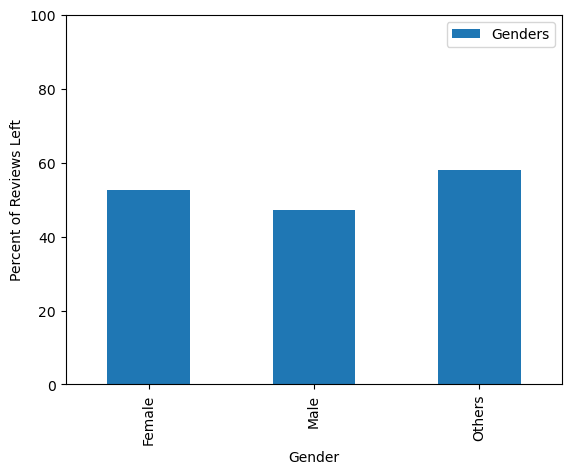

In [35]:
# Question 3: Review question – Eileen. Which type of consumer leaves the most reviews? The least?

#tornado graph


no_review = amazon_df["Review_Left"].eq('No').sum()
no_review

reviews_left = amazon_df["Review_Left"].eq('Yes').sum()
reviews_left


#group by gender
gender_counts = amazon_df.groupby("Gender")["Gender"].count().reset_index(name = "counts")
gender_counts

#group by gender and reviews left
gender_review_counts = amazon_df.groupby(["Gender", "Review_Left"]).size().reset_index(name='Count')
gender_review_counts

# Filter for women and men who said 'Yes'
women_yes_count = gender_review_counts[(gender_review_counts["Gender"] == 'Female') & (gender_review_counts["Review_Left"] == 'Yes')]['Count'].values[0]
men_yes_count = gender_review_counts[(gender_review_counts["Gender"] == 'Male') & (gender_review_counts["Review_Left"] == 'Yes')]['Count'].values[0]
others_yes_count = gender_review_counts[(gender_review_counts["Gender"] == 'Others') & (gender_review_counts["Review_Left"] == 'Yes')]['Count'].values[0]

#percentage of each gender who said yes
women_percentage =  women_yes_count/gender_counts[gender_counts['Gender'] == 'Female']['counts'].values[0]*100
men_percentage =  men_yes_count/gender_counts[gender_counts['Gender'] == 'Male']['counts'].values[0]*100
others_percentage =  others_yes_count/gender_counts[gender_counts['Gender'] == 'Others']['counts'].values[0]*100

percentage_of_reviews_by_gender = pd.DataFrame({
    'Genders': [women_percentage, men_percentage, others_percentage]}, index = ["Female", "Male", "Others"]
)
percentage_of_reviews_by_gender

reviews_by_gender_bar = percentage_of_reviews_by_gender.plot(kind="bar", ylim = (0,100))
reviews_by_gender_bar.set_ylabel("Percent of Reviews Left")
reviews_by_gender_bar.set_xlabel("Gender")

#add colors

#age

#category of items




In [ ]:
# Question 4: Is there a strong correlation between browsing frequency and purchase frequency?








